In [5]:
import os
import pandas as pd

!pip install hvplot
import hvplot.pandas

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#define spark version
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.0 MB/s eta 0:00:00


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [770 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,012 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,602 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:13 https:/

In [6]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Demographics").getOrCreate()

In [7]:
#Read in the data from the group github repo
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AlexFeeney/Project4_Group3/main/Data/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [8]:
#convert to pandas df
pandas_df = df.toPandas()


#check pandas df
pandas_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1


In [9]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [10]:
df_stroke=pandas_df
#df_stroke.head()

In [11]:
df_stroke["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
df_stroke["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [13]:
# NO TO BE 0 AND YES IS 1 IN EVER_MARRIED COLUMN

def ever_married(x):
    if x=="Yes":
        return 1
    else:
        return 0

df_stroke["ever_married"]=df_stroke["ever_married"].map(ever_married)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,Rural,166.29,25.6,formerly smoked,0


In [14]:
df_stroke["work_type"].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [15]:
df_stroke["Residence_type"].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [16]:
#1= urban, 0=rural
def Residence_type(x):
    if x=="Urban":
        return 1
    else:
        return 0

df_stroke["Residence_type"]=df_stroke["Residence_type"].map(Residence_type)
df_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,0,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,1,Private,1,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,1,Self-employed,1,125.2,40,never smoked,0
5107,19723,Female,35,0,0,1,Self-employed,0,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,1,Private,0,166.29,25.6,formerly smoked,0


CONVERTING ALL VALUES TO BINARY EXCEPT id,bmi,avg_glucose_level,stroke




In [17]:
# Step 1: Exclude 'id' and 'age' columns from df_stroke
df_stroke_subset = df_stroke.drop(columns=['id','bmi','avg_glucose_level','age','stroke'])

# Step 2: Get dummies for the remaining columns
df_dummies = pd.get_dummies(df_stroke_subset)

# Step 3: Concatenate 'id' and 'age' columns back to df_dummies
df_dummies[['id','bmi','avg_glucose_level', 'age','stroke']] = df_stroke[['id','bmi','avg_glucose_level', 'age','stroke']]

# Step 4: Ensure 'id' and 'age' columns are in the correct order
df_dummies = df_dummies[['id','bmi','avg_glucose_level','age','stroke'] + [col for col in df_dummies.columns if col not in ['id','bmi','avg_glucose_level', 'age','stroke']]]

# Now df_dummies will have binary columns for all categorical variables and 'id' and 'age' columns with their original values.
df_dummies

,id,bmi,avg_glucose_level,age,stroke,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,...,heart_disease_1,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,36.6,228.69,67,1,1,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
1,51676,N/A,202.21,61,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,32.5,105.92,80,1,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
3,60182,34.4,171.23,49,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,1
4,1665,24,174.12,79,1,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,N/A,83.75,80,0,1,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
5106,44873,40,125.2,81,0,1,1,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5107,19723,30.6,82.99,35,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
5108,37544,25.6,166.29,51,0,1,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


In [18]:

print(df_dummies.columns)


Index(['id', 'bmi', 'avg_glucose_level', 'age', 'stroke', 'ever_married',
       'Residence_type', 'gender_Female', 'gender_Male', 'gender_Other',
       'hypertension_0', 'hypertension_1', 'heart_disease_0',
       'heart_disease_1', 'work_type_Govt_job', 'work_type_Never_worked',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')


In [19]:

# df_dummies is your DataFrame containing dummy variables


# Extracting binary target variable
y = df_dummies["stroke"]
 # Assuming stroke_1 represents the positive class

# Dropping unnecessary columns from the feature matrix
X = df_dummies.drop(columns=["stroke"])

# Display the first few rows of the binary target variable
print(y.head())


0    1
1    1
2    1
3    1
4    1
Name: stroke, dtype: object


In [20]:
X.head()

,id,bmi,avg_glucose_level,age,ever_married,Residence_type,gender_Female,gender_Male,gender_Other,hypertension_0,...,heart_disease_1,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,36.6,228.69,67,1,1,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
1,51676,N/A,202.21,61,1,0,1,0,0,1,...,0,0,0,0,1,0,0,0,1,0
2,31112,32.5,105.92,80,1,0,0,1,0,1,...,1,0,0,1,0,0,0,0,1,0
3,60182,34.4,171.23,49,1,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,1
4,1665,24,174.12,79,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [21]:
df_dummies = df_dummies.drop(columns=['id'])

In [22]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=True, random_state=42)

# Making Predictions Using The Random Forest model

## replacing N/A values with NaN USING NP FROM numpy library
## imputing missing values numeric columns
## denfining X AND Y
## spliting data into 80:20 , train and test sets
## training data
## predict on testing data

In [30]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Replace 'N/A' with NaN in the specified columns
columns_to_replace_na = ['bmi', 'avg_glucose_level', 'age']
df_dummies[columns_to_replace_na] = df_dummies[columns_to_replace_na].replace('N/A', np.nan)
# Separate numeric and categorical columns
numeric_columns = ['bmi', 'avg_glucose_level', 'age']
categorical_columns = [col for col in df_dummies.columns if col not in numeric_columns]

# Impute missing values for numeric columns with the mean
numeric_imputer = SimpleImputer(strategy='mean')
df_dummies[numeric_columns] = numeric_imputer.fit_transform(df_dummies[numeric_columns])

# Impute missing values for categorical columns with the most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_dummies[categorical_columns] = categorical_imputer.fit_transform(df_dummies[categorical_columns])

# Separate features (X) and target variable (y)
X = df_dummies.drop(columns=['stroke'])
y = df_dummies['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier(n_estimators=500, random_state=48)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test)

# Calculating the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print("Confusion Matrix:\n", cm_df)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
           Predicted 0  Predicted 1
Actual 0          959            1
Actual 1           61            1
Accuracy: 0.9393346379647749
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.50      0.02      0.03        62

    accuracy                           0.94      1022
   macro avg       0.72      0.51      0.50      1022
weighted avg       0.91      0.94      0.91      1022



In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

# Assuming X_train and y_train are your training data
# Assuming X_test and y_test are your testing data
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
# Initialize lists to store scores for each iteration
scores = []

# Perform 11 iterations
for i in range(1, 12):
    # Create a RandomForestClassifier instance
    rf_classifier = RandomForestClassifier(max_depth=None, random_state=i)

    # Fit the classifier on training data
    rf_classifier.fit(X_train, y_train)

    # Predict on testing data
    y_pred = rf_classifier.predict(X_test)

    # Calculate precision, recall, and F1 scores
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='1')

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Append scores to the list
    scores.append([i, accuracy, precision, recall, f1])

# Print scores as a table
headers = ["Iteration", "Accuracy", "Precision", "Recall", "F1-score"]
print(tabulate(scores, headers=headers, tablefmt="grid"))


+-------------+------------+-------------+-----------+------------+
|   Iteration |   Accuracy |   Precision |    Recall |   F1-score |
+=============+============+=============+===========+============+
|           1 |   0.938356 |    0        | 0         |  0         |
+-------------+------------+-------------+-----------+------------+
|           2 |   0.938356 |    0        | 0         |  0         |
+-------------+------------+-------------+-----------+------------+
|           3 |   0.938356 |    0        | 0         |  0         |
+-------------+------------+-------------+-----------+------------+
|           4 |   0.939335 |    0.5      | 0.016129  |  0.03125   |
+-------------+------------+-------------+-----------+------------+
|           5 |   0.938356 |    0        | 0         |  0         |
+-------------+------------+-------------+-----------+------------+
|           6 |   0.940313 |    0.666667 | 0.0322581 |  0.0615385 |
+-------------+------------+-------------+------

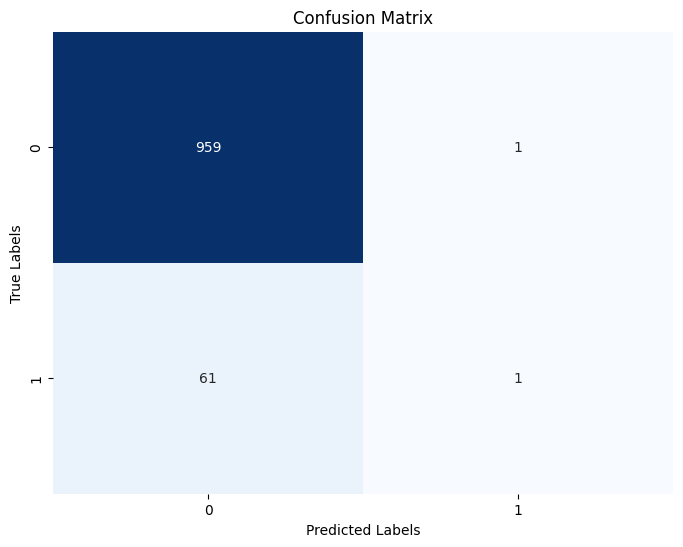

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()



# Feature Importance

In [40]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_classifier.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_classifier.feature_importances_, X.columns), reverse=True)

[(0.26618513362366314, 'avg_glucose_level'),
 (0.24016451071300607, 'age'),
 (0.22400801020058086, 'bmi'),
 (0.03541298211175332, 'Residence_type'),
 (0.020311604660504516, 'work_type_Private'),
 (0.0201068459520382, 'smoking_status_never smoked'),
 (0.02010125249822812, 'ever_married'),
 (0.0196622543846679, 'smoking_status_formerly smoked'),
 (0.01943505669390928, 'gender_Female'),
 (0.019138096048127447, 'smoking_status_smokes'),
 (0.018629162313588875, 'gender_Male'),
 (0.017484646640723942, 'work_type_Self-employed'),
 (0.01725850540886502, 'smoking_status_Unknown'),
 (0.012980298987539367, 'hypertension_0'),
 (0.01272180177172189, 'heart_disease_1'),
 (0.01255896329882613, 'work_type_Govt_job'),
 (0.011793751296662717, 'hypertension_1'),
 (0.010947874840038091, 'heart_disease_0'),
 (0.0010901170490679795, 'work_type_children'),
 (9.131506487012778e-06, 'work_type_Never_worked'),
 (0.0, 'gender_Other')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

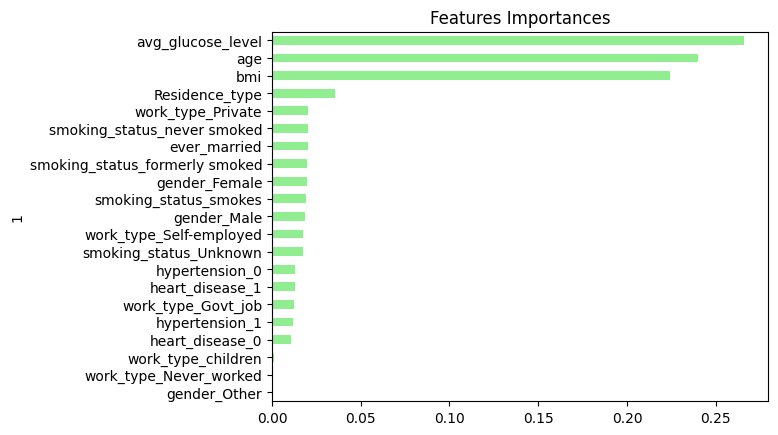

In [41]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip( rf_classifier.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

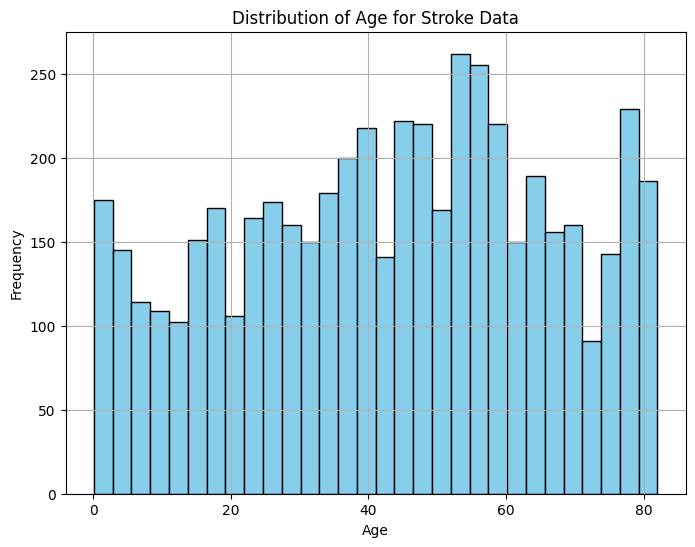

In [43]:
import matplotlib.pyplot as plt

# Replace 'age' with the name of the column containing age data
age_data = df_dummies['age']

# Create histogram
plt.figure(figsize=(8, 6))
plt.hist(age_data, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age for Stroke Data')
plt.grid(True)
plt.show()


PEFORMANCE OF RANDOM FORREST MODEL


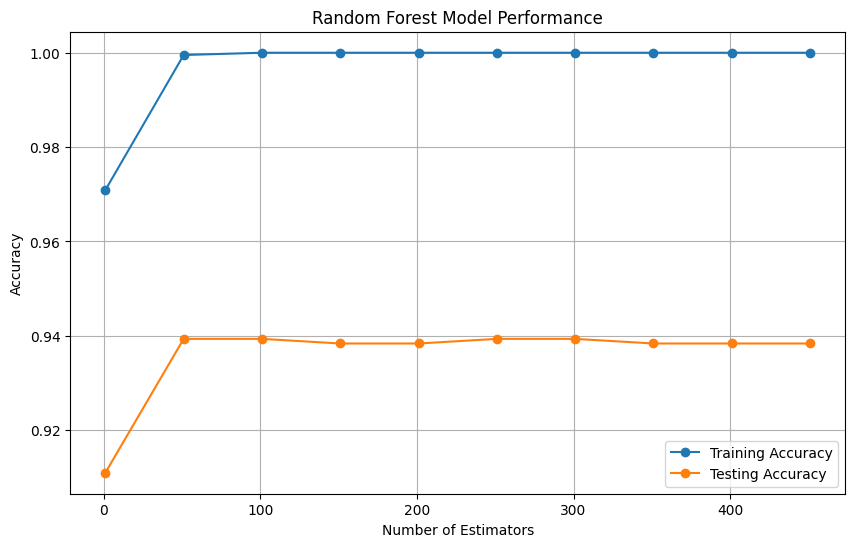

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into features (X) and target variable (y)
X = df_dummies.drop(columns=['stroke'])
y = df_dummies['stroke']

# Initialize lists to store training and testing accuracy
train_accuracy = []
test_accuracy = []

# Varying number of trees in the forest
n_estimators_range = range(1, 501, 50)

# Train a Random Forest model for each number of estimators
for n_estimators in n_estimators_range:
    # Create a RandomForestClassifier instance
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train the classifier on the training data
    rf_classifier.fit(X_train, y_train)

    # Predict on the training and testing data
    y_train_pred = rf_classifier.predict(X_train)
    y_test_pred = rf_classifier.predict(X_test)

    # Calculate accuracy for training and testing sets
    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

# Plotting the accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(n_estimators_range, test_accuracy, label='Testing Accuracy', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Model Performance')
plt.legend()
plt.grid(True)
plt.show()
